## Smart E - Learning Framework Using Deep Q - Network of Reinforcement Learning

### Installing the Necessary Libraries

In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 35.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00:00:01
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=c21cfcf1ee891da66c83887cdbe3058a9799576e0d06f9d200d8ef07c83e4335
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
/bin/sh: apt-get: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.5 MB/s eta 0:00:00:00:01
  Created wheel 

### Importing the Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import gymnasium as gym
from gymnasium import spaces

from collections import deque, namedtuple

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Input
from keras.losses import MSE
from keras.optimizers import Adam

2024-03-18 14:51:19.253569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:51:29.436141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Defining the States for the Environment

In [3]:
states = ['Start', 'Reading', 'Watching', 'Entertaining', 'Getting Bored', 'Rest', 'Writing', 'Playing', 'Clicking Ad', 'Course Completion', 'Quit']

for i in range(len(states)) :
    print("State {}: {}".format(i+1, states[i]))

State 1: Start
State 2: Reading
State 3: Watching
State 4: Entertaining
State 5: Getting Bored
State 6: Rest
State 7: Writing
State 8: Playing
State 9: Clicking Ad
State 10: Course Completion
State 11: Quit


### Defining the Actions for the Environment

In [4]:
actions = ['Stay', 'Previous Course', 'Additional Content', 'Do assignment', 'Move to Exams', 'Move to high-level course', 'Move to low-level course', 'Move to Social Media']

for i in range(len(actions)) :
    print("Action {}: {}".format(i+1, actions[i]))

Action 1: Stay
Action 2: Previous Course
Action 3: Additional Content
Action 4: Do assignment
Action 5: Move to Exams
Action 6: Move to high-level course
Action 7: Move to low-level course
Action 8: Move to Social Media


### Assigning Rewards for each action to be taken respectively

In [5]:
rewards = {}
rewardPoints = [10, 20, 50, 60, 100, 100, 70, -10]

for i in range(len(actions)) :
    rewards['{}'.format(actions[i])] = rewardPoints[i]

keys = list(rewards.keys())
for i in range(len(rewards)) :
    print("Action: {}\tReward Points: {}".format(keys[i], rewards.get(keys[i])))

Action: Stay	Reward Points: 10
Action: Previous Course	Reward Points: 20
Action: Additional Content	Reward Points: 50
Action: Do assignment	Reward Points: 60
Action: Move to Exams	Reward Points: 100
Action: Move to high-level course	Reward Points: 100
Action: Move to low-level course	Reward Points: 70
Action: Move to Social Media	Reward Points: -10


### Customizing the State values for the Custom Environment

In [6]:
customStates = {}

currentStateNumber = 0.0

for state in states :
    customStates['{}'.format(state)] = currentStateNumber
    currentStateNumber += 1

for key in list(customStates.keys()) :
    print("State: {}\tAssigned State Number: {}".format(key, customStates[key]))

finalStateForm = np.array(list(customStates.values())).astype(np.float32)

State: Start	Assigned State Number: 0.0
State: Reading	Assigned State Number: 1.0
State: Watching	Assigned State Number: 2.0
State: Entertaining	Assigned State Number: 3.0
State: Getting Bored	Assigned State Number: 4.0
State: Rest	Assigned State Number: 5.0
State: Writing	Assigned State Number: 6.0
State: Playing	Assigned State Number: 7.0
State: Clicking Ad	Assigned State Number: 8.0
State: Course Completion	Assigned State Number: 9.0
State: Quit	Assigned State Number: 10.0


### Creating and Registering the Environment in Gymnasium

In [7]:
class ELearningEnv(gym.Env) :
    def __init__(self) :
        super(ELearningEnv, self).__init__()
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.num_states = len(self.states)
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_states, ))
        self.current_state = self.observation_space.sample()

    def reset(self) :
        self.current_state = np.zeros(shape=self.num_states, dtype=np.float32)
        self.current_state[0] = 1
        return self.current_state

    def step(self, action) :
        reward = self.rewards.get(self.actions[action], 0)
        done = (self.states[np.argmax(self.current_state)] in ['Course Completion', 'Quit'])
        if not done :
            if action == 0 :
                pass
            elif action == 1 :
                self.current_state = np.roll(self.current_state, -1)
            elif action == 2 :
                self.current_state = np.roll(self.current_state, 1)
            elif action == 3 :
                self.current_state = np.roll(self.current_state, 2)
            elif action == 4 :
                self.current_state = np.roll(self.current_state, 3)
            elif action == 5 :
                self.current_state = np.roll(self.current_state, 4)
            elif action == 6 :
                self.current_state = np.roll(self.current_state, 5)
            elif action == 7 :
                self.current_state = np.roll(self.current_state, 6)
        return self.current_state, reward, done, {}

    def render(self, mode = "human") :
        print(f"Current State: {self.states[np.argmax(self.current_state)]}")

gym.register(id="ELearningEnv-v1", entry_point="__main__:ELearningEnv")

### Setting the Seeding value for the Environment

In [8]:
tf.random.set_seed(0)

### Defining the Hyperparameters

In [9]:
MEMORY_SIZE = 100_000
GAMMA = 0.995
ALPHA = 1e-3
NUM_STEPS_FOR_EPISODE = 4

### Defining the Environment for use

In [10]:
env = gym.make("ELearningEnv-v1")
env.reset()

state_size = env.observation_space.shape
action_size = env.action_space.n

print("Number of States Available: ", state_size, "\nNumber of Actions: ", action_size)

Number of States Available:  (11,) 
Number of Actions:  8


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  lo

### Reset the Environment

In [11]:
current_state = env.reset()
print("Current State: {}".format(current_state))

Current State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Test the Environment for a action

In [12]:
action = 4

next_state, reward, done, _ = env.step(action)

env.render()

Current State: Entertaining


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


### Create the Deep Neural Network for the Q - Network

In [13]:
QNetwork = Sequential(
    [
        Input(shape=state_size),
        Dense(units=64, activation="relu"),
        Dense(units=128, activation="relu"),
        # Dense(units=256, activation="relu"),
        # Dense(units=128, activation="relu"),
        Dense(units=64, activation="relu"),
        Dense(units=action_size, activation="linear")
    ]
)

target_QNetwork = Sequential(
    [
        Input(shape=state_size),
        Dense(units=64, activation="relu"),
        Dense(units=128, activation="relu"),
        # Dense(units=256, activation="relu"),
        # Dense(units=128, activation="relu"),
        Dense(units=64, activation="relu"),
        Dense(units=action_size, activation="linear")
    ]
)

optimizer = Adam(learning_rate=ALPHA)

2024-03-18 14:52:51.631020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 14:52:59.913034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-18 14:52:59.913305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Implementing Experience Replay

In [14]:
experience = namedtuple(typename="Experience", field_names=["state", "action", "reward", "next_state", "done"])

### Defining Compute Loss function for the Deep Q - Learning with Experience Replay

In [15]:
def compute_loss(experiences, gamma, QNetwork, target_QNetwork) :

    # Unpack the mini-batch of experiences
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(input_tensor=target_QNetwork(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + gamma max Q^(s,a)
    yTargets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values and reshape to match y_targets
    q_values = QNetwork(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis = 1))
    
    # Compute the Loss
    loss = MSE(yTargets, q_values)

    return loss

### Update the Target Network Weights

In [16]:
TAU = 1e-3 # Soft update parameter

def update_target_network(QNetwork, target_QNetwork) :
    for targetWeights, QNetWeights in zip(target_QNetwork.weights, QNetwork.weights) :
        targetWeights.assign(TAU * QNetWeights + (1.0 - TAU) * targetWeights)

### Getting the Action based on Epsilon-greedy policy

In [17]:
import random

def get_action(q_values, epsilon=0.0) :

    # Returns an action based on the Epsilon-greedy policy

    if random.random() > epsilon :
        return np.argmax(q_values.numpy()[0])
    return random.choice(np.arange(8))

### Checking the Update conditions for the network

In [18]:
MINIBATCH_SIZE = 100

def check_update_conditions(t, num_steps_upd, memory_buffer) :

    # Returns a boolean that will be True if the conditions are met and False otherwise.

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE :
        return True
    return False

### Getting the Experiences Randomly from the Memory Buffer

In [19]:
def get_experiences(memory_buffer) :

    # Returns a random sample of experience tuples drawn from the memory buffer.
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

### Updating the Epsilon value

In [20]:
EPSILON_MIN = 0.01 # Minimum Epsilon value for the Epsilon-greedy policy
EPSILON_DECAY = 0.995 # Epsilon-decay rate for the Epsilon-greedy policy

def get_new_epsilon(epsilon) :

    # Returns the updated Epsilon value for the Epsilon-greedy policy

    return max(EPSILON_MIN, EPSILON_DECAY * epsilon)

### Update the Network Weights

In [21]:
@tf.function
def agent_learn(experiences, gamma) :
    
    # Calculate the loss
    with tf.GradientTape() as tape :
        loss = compute_loss(experiences, gamma, QNetwork, target_QNetwork)

    # Get the Gradients of the loss with respect to the weights
    gradients = tape.gradient(loss, QNetwork.trainable_variables)

    # Update the weights of the QNetwork
    optimizer.apply_gradients(zip(gradients, QNetwork.trainable_variables))

    # Update the Weights of the Target QNetwork
    update_target_network(QNetwork, target_QNetwork)

### Defining the structure for training the Agent

In [22]:
import time

from numpy import float32

def AgentTrain(numberOfEpisodes, maximumNumberTimesteps) :
    
    start = time.time()

    totalPointHistory = []
    totalQValues = []

    numberPointAverage = 10 # Number of total points to use for averaging
    epsilon = 1.0 # Initial Epsilon value for Epsilon-greedy policy

    # Create a memory buffer D with capacity N
    memory_buffer = deque(maxlen=MEMORY_SIZE)

    # Set the target network weights equal to the Q-Network weights
    target_QNetwork.set_weights(QNetwork.get_weights())

    for i in range(numberOfEpisodes) :

        # Reset the environment to the initial state and get the initial state
        state = env.reset()
        # state_oneHot = np.zeros(shape=(len(states),), dtype=float32)
        # state_oneHot[state] = 1

        totalPoints = 0
        EpisodeQValues = 0

        for t in range(maximumNumberTimesteps) :

            # From the current state S, choose an action A using an Epsilon-greedy policy
            state_qn = tf.expand_dims(state, axis=0) # State needs to be the right shape for the Q-Network
            q_values = QNetwork(state_qn)
            EpisodeQValues += q_values
            action = get_action(q_values, epsilon)

            # Take action A and receive reward R and the next state S'
            next_state, reward, done, _ = env.step(action)

            # Store experience tuple (S,A,R,S') in the memory buffer
            # Storing the done variable for our convenience
            memory_buffer.append(experience(state, action, reward, next_state, done))

            # Update the network only after every NUM_STEPS_FOR_UPDATE timesteps.
            update = check_update_conditions(t, NUM_STEPS_FOR_EPISODE, memory_buffer)

            if update :

                # Sample random mini-batch of experience tuples (S,A,R,S') from D
                experiences = get_experiences(memory_buffer)

                # Set the y-targets, perform a gradient descent step,
                # and update the network weights"
                agent_learn(experiences, GAMMA)

            state = next_state
            totalPoints += reward

            if done :
                break

        totalPointHistory.append(totalPoints)
        totalQValues.append(EpisodeQValues)
        averageLatestPoints = np.mean(totalPointHistory[-numberPointAverage:])

        # Update the Epsilon value
        epsilon = get_new_epsilon(epsilon)

        print(f"\rEpisode {i+1} | Total point average of the last {numberPointAverage} episodes: {averageLatestPoints:.2f}", end="")

        if (i + 1) % numberPointAverage == 0 :
            print(f"\rEpisode {i+1} | Total point average of the last {numberPointAverage} episodes: {averageLatestPoints:.2f}")

    totalTimeTaken = time.time() - start

    print(f"Total Runtime of the Agent Training: {totalTimeTaken:.2f} s ({(totalTimeTaken / 60):.2f} mins)")

    return totalPointHistory, totalQValues


### Analyzing the Performance of the algorithm

In [51]:
def algorithmPerformance(totalPointHistory, totalQValues) :

    print("\n\nPERFORMANCE OF THE ALGORITHM BY THE AGENT\n\n")

    averageReward = np.mean(totalPointHistory)
    print("Average Reward generated for each episode: ", averageReward)

    averageQValues = np.mean(totalQValues)
    print("Average Q - Value generated for each episode ", averageQValues)

    successfulEpisodes = 0
    for rewards in totalPointHistory :
        if rewards > 450 :
            successfulEpisodes += 1
    averageSuccessRate = ((successfulEpisodes / len(totalPointHistory)) * 100)
    print("Average Success Rate of the algorithm: ", averageSuccessRate)

SyntaxError: invalid syntax (1097196653.py, line 16)

### Plotting the Agent Performance with generated rewards

In [24]:
def PlottingRewards(totalPointHistory):
    plt.plot(totalPointHistory)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards generated for {} episodes'.format(len(totalPointHistory)))
    plt.grid(True)

    # Save the plot as an image
    plt.savefig("Rewards_{}_Episodes.jpg".format(len(totalPointHistory)), format='jpg')

    # Show the generated plot
    plt.show()

### Training the Agent with 100 episodes

Training Results of the agent training for the 100 episodes


Episode 10 | Total point average of the last 10 episodes: 260.00
Episode 15 | Total point average of the last 10 episodes: 404.00

2024-03-18 14:54:32.235205: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f16c1002500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 14:54:32.235241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-03-18 14:54:32.865660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-18 14:54:33.666085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-03-18 14:54:36.054483: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode 20 | Total point average of the last 10 episodes: 503.00
Episode 30 | Total point average of the last 10 episodes: 377.00
Episode 40 | Total point average of the last 10 episodes: 548.00
Episode 50 | Total point average of the last 10 episodes: 323.00
Episode 60 | Total point average of the last 10 episodes: 250.00
Episode 70 | Total point average of the last 10 episodes: 641.00
Episode 80 | Total point average of the last 10 episodes: 362.00
Episode 90 | Total point average of the last 10 episodes: 402.00
Episode 100 | Total point average of the last 10 episodes: 512.00
Total Runtime of the Agent Training: 11.07 s (0.18 mins)
Average Reward generated for each episode:  417.8
Average Q - Value generated for each episode  133.70694


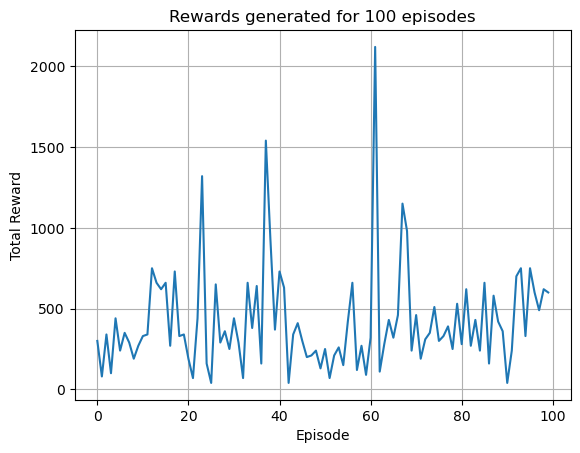

In [25]:
# Defining the number of episodes
numberEpisodes = 100

# Defining the maximum number of timesteps for each episode
maximumNumberTimesteps = 1000

print("Training Results of the agent training for the {} episodes\n\n".format(numberEpisodes))
totalPointHistory, totalQValues = AgentTrain(numberOfEpisodes=numberEpisodes, maximumNumberTimesteps=maximumNumberTimesteps)
algorithmPerformance(totalPointHistory, totalQValues)
PlottingRewards(totalPointHistory)

### Training the Agent with 200 epsiodes

Training Results of the agent training for the 200 episodes


Episode 10 | Total point average of the last 10 episodes: 212.00
Episode 20 | Total point average of the last 10 episodes: 465.00
Episode 30 | Total point average of the last 10 episodes: 568.00
Episode 40 | Total point average of the last 10 episodes: 448.00
Episode 50 | Total point average of the last 10 episodes: 436.00
Episode 60 | Total point average of the last 10 episodes: 547.00
Episode 70 | Total point average of the last 10 episodes: 417.00
Episode 80 | Total point average of the last 10 episodes: 400.00
Episode 90 | Total point average of the last 10 episodes: 496.00
Episode 100 | Total point average of the last 10 episodes: 484.00
Episode 110 | Total point average of the last 10 episodes: 230.00
Episode 120 | Total point average of the last 10 episodes: 611.00
Episode 130 | Total point average of the last 10 episodes: 576.00
Episode 140 | Total point average of the last 10 episodes: 817.00
Episode 150 | Total poi

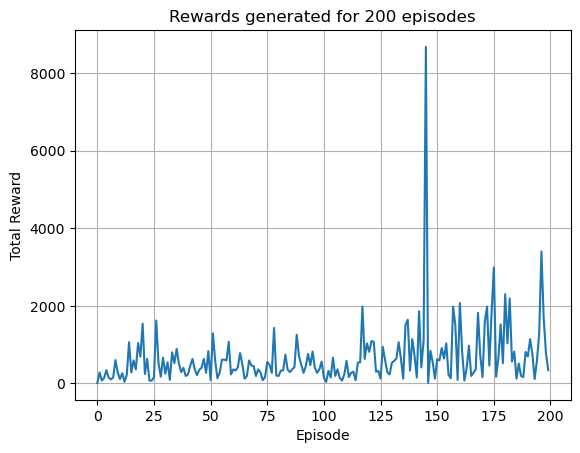

In [28]:
# Defining the number of episodes
numberEpisodes = 200

# Defining the maximum number of timesteps for each episode
maximumNumberTimesteps = 1000

print("Training Results of the agent training for the {} episodes\n\n".format(numberEpisodes))
totalPointHistory, totalQValues = AgentTrain(numberOfEpisodes=numberEpisodes, maximumNumberTimesteps=maximumNumberTimesteps)
algorithmPerformance(totalPointHistory, totalQValues)
PlottingRewards(totalPointHistory)

### Training the Agent with 500 episodes

Training Results of the agent training for the 500 episodes


Episode 10 | Total point average of the last 10 episodes: 405.00
Episode 20 | Total point average of the last 10 episodes: 371.00
Episode 30 | Total point average of the last 10 episodes: 446.00
Episode 40 | Total point average of the last 10 episodes: 561.00
Episode 50 | Total point average of the last 10 episodes: 438.00
Episode 60 | Total point average of the last 10 episodes: 635.00
Episode 70 | Total point average of the last 10 episodes: 554.00
Episode 80 | Total point average of the last 10 episodes: 705.00
Episode 90 | Total point average of the last 10 episodes: 700.00
Episode 100 | Total point average of the last 10 episodes: 465.00
Episode 110 | Total point average of the last 10 episodes: 837.00
Episode 120 | Total point average of the last 10 episodes: 738.00
Episode 130 | Total point average of the last 10 episodes: 657.00
Episode 140 | Total point average of the last 10 episodes: 849.00
Episode 150 | Total poi

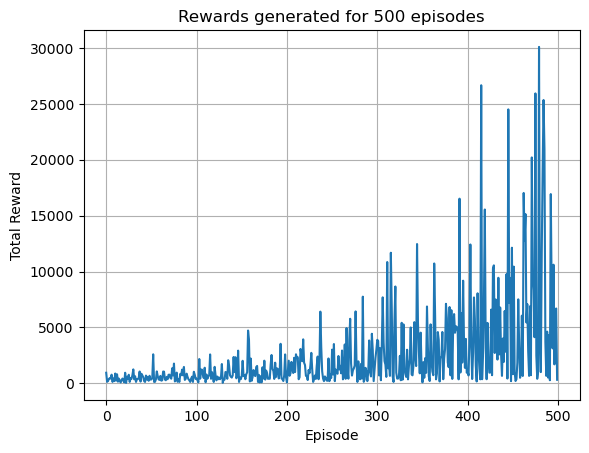

In [31]:
# Defining the number of episodes
numberEpisodes = 500

# Defining the maximum number of timesteps for each episode
maximumNumberTimesteps = 1000

print("Training Results of the agent training for the {} episodes\n\n".format(numberEpisodes))
totalPointHistory, totalQValues = AgentTrain(numberOfEpisodes=numberEpisodes, maximumNumberTimesteps=maximumNumberTimesteps)
algorithmPerformance(totalPointHistory, totalQValues)
PlottingRewards(totalPointHistory)